In [1]:

import matplotlib.pyplot as plt
from obspy.clients.fdsn import Client
import obspy

import torch
from chronos import ChronosPipeline
import numpy as np

/Users/marinedenolle/opt/miniconda3/envs/quakellm/lib/python3.11/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
prediction_length = 64

## SCEDC catalog

In [3]:
# Create a client to connect to the SCEDC data center
client = Client("SCEDC")

# download a SCEDC earthquake catalog using obspy
starttime = obspy.UTCDateTime("2016-01-01")
endtime = obspy.UTCDateTime("2020-01-01")
minlatitude = 32.0
minlongitude = -125.0
maxlatitude = 42.0
maxlongitude = -114.0
minmagnitude = 2.7
quake_catalog = client.get_events(starttime=starttime,\
             endtime=endtime, minlatitude=minlatitude, \
                minlongitude=minlongitude, maxlatitude=maxlatitude, \
                    maxlongitude=maxlongitude, minmagnitude=minmagnitude)

In [4]:
# next, we will count the number of events per day and store that as a pandas data frame with a datetme index
from collections import Counter
from pandas import DataFrame, to_datetime
import pandas as pd

# Extract event times
event_times = [event.origins[0].time.date for event in quake_catalog]

# Count the number of events per day
event_counts = Counter(event_times)

# Convert the counts to a pandas DataFrame
event_counts_df = DataFrame.from_dict(event_counts, orient='index', columns=['target'])

# Convert the index to datetime
event_counts_df.index = to_datetime(event_counts_df.index)

# Sort the DataFrame by date
event_counts_df = event_counts_df.sort_index()

# Print the DataFrame
print(event_counts_df)

            target
2016-01-02       1
2016-01-03       1
2016-01-06       2
2016-01-07       1
2016-01-09       1
...            ...
2019-12-25       3
2019-12-26       2
2019-12-27       1
2019-12-28       3
2019-12-30       1

[713 rows x 1 columns]


In [5]:
# Identify the frequency of your time series
freq = 'D'  # Daily frequency

# Create a new index with the desired frequency
new_index = pd.date_range(start=event_counts_df.index.min(), end=event_counts_df.index.max(), freq=freq)

# Reindex the DataFrame to fill in any missing dates
event_counts_df = event_counts_df.reindex(new_index)

# Fill missing values (e.g., forward fill)
event_counts_df.fillna(method='ffill', inplace=True)

# Rename the count column to target
event_counts_df = event_counts_df.rename(columns={'count': 'target'})

# Now dataset is a PandasDataset compatible with GluonTS

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/2540546850.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  event_counts_df.fillna(method='ffill', inplace=True)


(0.0, 100.0)

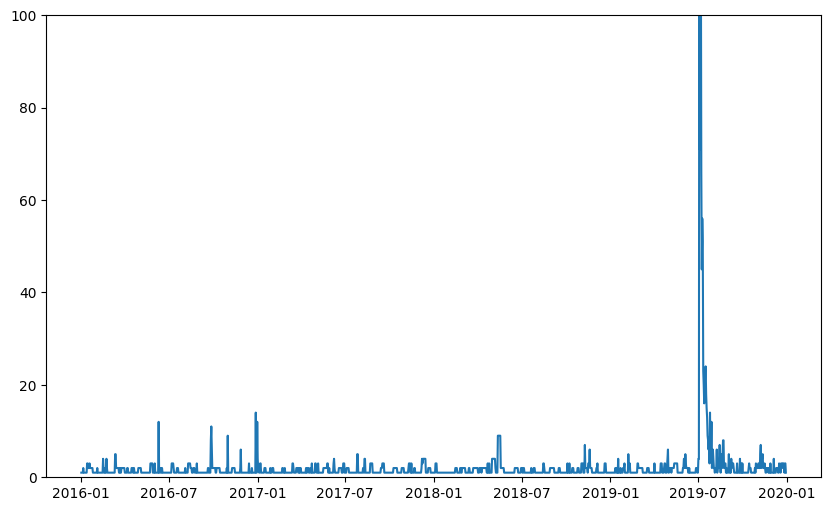

In [6]:
# plot the number of events per day
plt.figure(figsize=(10, 6))
plt.plot(event_counts_df.index, event_counts_df['target'])
plt.ylim([0, 100])

Make monthly time series

In [7]:
import pandas as pd

# Assuming event_counts is a dictionary with dates as keys and counts as values
# Convert the dictionary to a DataFrame
event_counts_df = pd.DataFrame(list(event_counts.items()), columns=['date', 'count'])

# Convert the date column to datetime
event_counts_df['date'] = pd.to_datetime(event_counts_df['date'])

# Normalize the dates to the first day of the month
event_counts_df['month'] = event_counts_df['date'].dt.to_period('M')

# Aggregate the counts by month
monthly_event_counts = event_counts_df.groupby('month')['count'].sum().reset_index()

# Convert the 'month' column back to datetime for easier plotting
monthly_event_counts['month'] = monthly_event_counts['month'].dt.to_timestamp()

print(monthly_event_counts)

        month  count
0  2016-01-01     22
1  2016-02-01     30
2  2016-03-01     20
3  2016-04-01     18
4  2016-05-01     16
5  2016-06-01     32
6  2016-07-01     17
7  2016-08-01     24
8  2016-09-01     39
9  2016-10-01     25
10 2016-11-01     19
11 2016-12-01     44
12 2017-01-01     22
13 2017-02-01     12
14 2017-03-01     22
15 2017-04-01     23
16 2017-05-01     23
17 2017-06-01     24
18 2017-07-01     17
19 2017-08-01     15
20 2017-09-01     17
21 2017-10-01     16
22 2017-11-01     19
23 2017-12-01     23
24 2018-01-01     17
25 2018-02-01     20
26 2018-03-01     15
27 2018-04-01     21
28 2018-05-01     25
29 2018-06-01     11
30 2018-07-01     18
31 2018-08-01     18
32 2018-09-01     18
33 2018-10-01     23
34 2018-11-01     30
35 2018-12-01     16
36 2019-01-01     24
37 2019-02-01     22
38 2019-03-01     12
39 2019-04-01     31
40 2019-05-01     18
41 2019-06-01     33
42 2019-07-01   1738
43 2019-08-01     95
44 2019-09-01     44
45 2019-10-01     37
46 2019-11-01

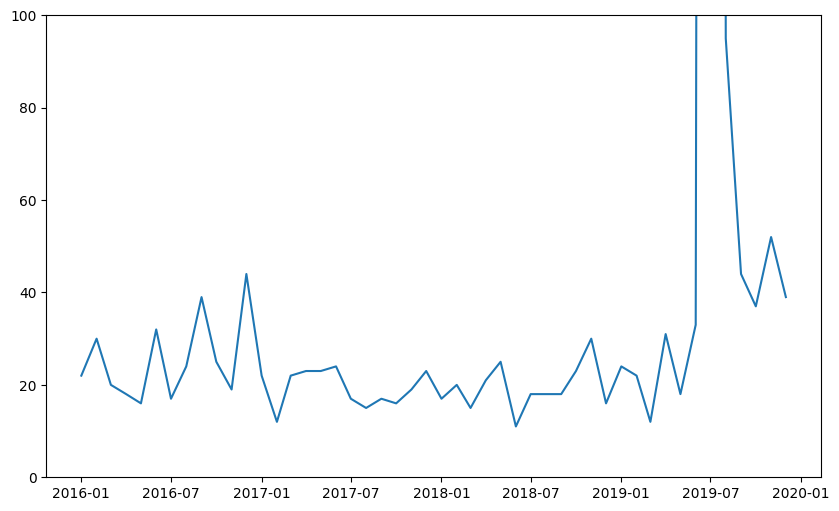

In [8]:
# plot the number of events per month
plt.figure(figsize=(10, 6))
plt.plot(monthly_event_counts['month'], monthly_event_counts['count'])
plt.ylim([0, 100])
# plt.plot( event_counts_df['count'])
plt.show()

In [9]:
# save the data to a csv file
monthly_event_counts.to_csv('data_scedc_catalog.csv', index=False)


QTM earthquake catalog

In [12]:
# load the data from https://service.scedc.caltech.edu/ftp/QTMcatalog/qtm_final_12dev.hypo
import requests
r = requests.get('https://service.scedc.caltech.edu/ftp/QTMcatalog/qtm_final_12dev.hypo')
# write the content to a file
with open('qtm_final_12dev.hypo', 'wb') as f:
    f.write(r.content)


# and save it to a csv file
data = pd.read_csv('qtm_final_12dev.hypo', delim_whitespace=True, header=None)
# convert numerical columns to float
data = data.apply(pd.to_numeric, errors='ignore')
data.head()


/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/517141884.py:10: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('qtm_final_12dev.hypo', delim_whitespace=True, header=None)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,EVENTID,LATITUDE,LONGITUDE,DEPTH,MAGNITUDE,MAGP5,MAGP95,TEMPLATEID,STACKCC,MAD,RELOCATED?
1,2008,01,01,00,04,12.531,2,33.26719,-116.28997,11.567,0.78,0.59,0.90,37614600,0.348,0.026,1
2,2008,01,01,00,04,18.539,3,33.45944,-116.58639,10.438,0.37,0.27,0.48,10310729,0.515,0.018,1
3,2008,01,01,00,07,32.377,4,33.59068,-116.63390,13.378,0.38,0.28,0.47,37190560,0.404,0.017,1
4,2008,01,01,00,58,57.842,10,33.49528,-116.49165,11.818,0.05,-0.10,0.18,15538673,0.216,0.014,1


In [22]:
# print first row of data
print(data.iloc[0])

0           YEAR
1          MONTH
2            DAY
3           HOUR
4         MINUTE
5         SECOND
6        EVENTID
7       LATITUDE
8      LONGITUDE
9          DEPTH
10     MAGNITUDE
11         MAGP5
12        MAGP95
13    TEMPLATEID
14       STACKCC
15           MAD
16    RELOCATED?
Name: 0, dtype: object


In [25]:
# rename the first row as the column names
data.columns = data.iloc[0]
# remove the first row
data = data[1:]

In [26]:
data.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,EVENTID,LATITUDE,LONGITUDE,DEPTH,MAGNITUDE,MAGP5,MAGP95,TEMPLATEID,STACKCC,MAD,RELOCATED?
1,2008,01,01,00,04,12.531,2,33.26719,-116.28997,11.567,0.78,0.59,0.90,37614600,0.348,0.026,1
2,2008,01,01,00,04,18.539,3,33.45944,-116.58639,10.438,0.37,0.27,0.48,10310729,0.515,0.018,1
3,2008,01,01,00,07,32.377,4,33.59068,-116.63390,13.378,0.38,0.28,0.47,37190560,0.404,0.017,1
4,2008,01,01,00,58,57.842,10,33.49528,-116.49165,11.818,0.05,-0.10,0.18,15538673,0.216,0.014,1
5,2008,01,01,01,59,49.150,14,33.17647,-115.59904,3.485,-0.53,-0.78,-0.29,14375564,0.312,0.023,0


In [33]:
#convert month, day, hour, minutes to floats
data['MONTH'] = data['MONTH'].astype(int)
data['DAY'] = data['DAY'].astype(int)
data['HOUR'] = data['HOUR'].astype(int)
data['MINUTE'] = data['MINUTE'].astype(int)

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/1279807447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MONTH'] = data['MONTH'].astype(int)
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/1279807447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DAY'] = data['DAY'].astype(int)
/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/1279807447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

In [34]:
data.head()

,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,EVENTID,LATITUDE,LONGITUDE,DEPTH,MAGNITUDE,MAGP5,MAGP95,TEMPLATEID,STACKCC,MAD,RELOCATED?
1,2008,1,1,0,4,12.531,2,33.26719,-116.28997,11.567,0.78,0.59,0.90,37614600,0.348,0.026,1
2,2008,1,1,0,4,18.539,3,33.45944,-116.58639,10.438,0.37,0.27,0.48,10310729,0.515,0.018,1
3,2008,1,1,0,7,32.377,4,33.59068,-116.63390,13.378,0.38,0.28,0.47,37190560,0.404,0.017,1
4,2008,1,1,0,58,57.842,10,33.49528,-116.49165,11.818,0.05,-0.10,0.18,15538673,0.216,0.014,1
5,2008,1,1,1,59,49.150,14,33.17647,-115.59904,3.485,-0.53,-0.78,-0.29,14375564,0.312,0.023,0


In [36]:
# convert month, day, hour, minute seconds to a datetime object
data['datetime'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']])
data.head()

/var/folders/js/lzmy975n0l5bjbmr9db291m00000gn/T/ipykernel_54623/1150076383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datetime'] = pd.to_datetime(data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'SECOND']])


,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,EVENTID,LATITUDE,LONGITUDE,DEPTH,MAGNITUDE,MAGP5,MAGP95,TEMPLATEID,STACKCC,MAD,RELOCATED?,datetime
1,2008,1,1,0,4,12.531,2,33.26719,-116.28997,11.567,0.78,0.59,0.90,37614600,0.348,0.026,1,2008-01-01 00:04:12.531
2,2008,1,1,0,4,18.539,3,33.45944,-116.58639,10.438,0.37,0.27,0.48,10310729,0.515,0.018,1,2008-01-01 00:04:18.539
3,2008,1,1,0,7,32.377,4,33.59068,-116.63390,13.378,0.38,0.28,0.47,37190560,0.404,0.017,1,2008-01-01 00:07:32.377
4,2008,1,1,0,58,57.842,10,33.49528,-116.49165,11.818,0.05,-0.10,0.18,15538673,0.216,0.014,1,2008-01-01 00:58:57.842
5,2008,1,1,1,59,49.150,14,33.17647,-115.59904,3.485,-0.53,-0.78,-0.29,14375564,0.312,0.023,0,2008-01-01 01:59:49.150


In [37]:
# count the number of earthquakes per day with the datetime column
daily_earthquakes = data.groupby(data['datetime'].dt.date).size()

In [38]:
daily_earthquakes.head()

datetime
2008-01-01    120
2008-01-02     89
2008-01-03    146
2008-01-04    166
2008-01-05     94
dtype: int64

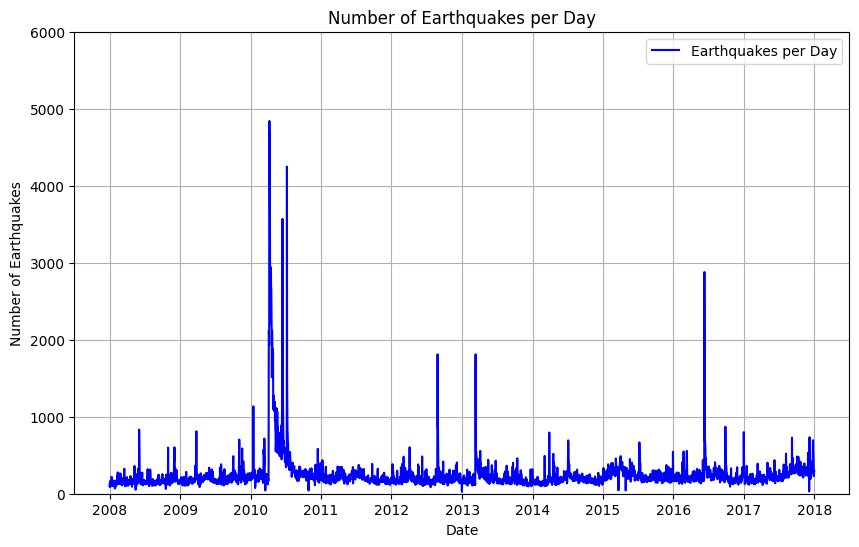

In [42]:
import matplotlib.pyplot as plt

# Plot the number of earthquakes per day
plt.figure(figsize=(10, 6))
plt.plot(daily_earthquakes.index, daily_earthquakes.values, color='b', label='Earthquakes per Day')

# Set the y-axis limit
plt.ylim([0, 6000])

# Add title and labels
plt.title('Number of Earthquakes per Day')
plt.xlabel('Date')
plt.ylabel('Number of Earthquakes')

# Add grid
plt.grid(True)

# Add legend
plt.legend()

# Show the plot
plt.show()

In [43]:
# save the data to a csv file, only the columns 'datetime' and 'count'
daily_earthquakes = daily_earthquakes.reset_index()
daily_earthquakes.columns = ['datetime', 'count']
daily_earthquakes.to_csv('data_qtm_catalog.csv', index=False)

Synthetic Quake Catalog